# "Хакерство" для **When Vision Transformers Outperform ResNets without Pre-training or Strong Data Augmentations**

https://arxiv.org/abs/2106.01548

### Скачиваем репозиторий от авторов статьи, устанавливаем requirements и подкачиваем веса модели (ну типа)

In [ ]:
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull
!pip install -qr vision_transformer/vit_jax/requirements.txt
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

Cloning into 'vision_transformer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 4), reused 33 (delta 4), pack-reused 0
Unpacking objects: 100% (37/37), done.
Already up to date.
     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 176 kB 41.1 MB/s 
     |████████████████████████████████| 88 kB 8.3 MB/s 
     |████████████████████████████████| 179.8 MB 64 kB/s 
     |████████████████████████████████| 126 kB 61.2 MB/s 
gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/

### Ставим питоновскую утилиту, чтобы скачать немного картинок с ImageNet

Скачаем несколько картинок из классов:
1. geyser
2. bee
3. eft

Чтобы выбрать другие классы, можно найти их в списке классов ImageNet https://image-net.org/challenges/LSVRC/2012/browse-synsets.php и прописать в параметр `class_list` скрипта в следующей ячейке

In [ ]:
N_SAMPLES_PER_CLASS = 100

![ -d ImageNet-Datasets-Downloader ] || git clone https://github.com/mf1024/ImageNet-Datasets-Downloader.git
!python ./ImageNet-Datasets-Downloader/downloader.py \
    -data_root . \
    -number_of_classes 3 \
    -use_class_list True \
    -class_list n09288635 n02206856 n01631663 \
    -images_per_class $N_SAMPLES_PER_CLASS

Cloning into 'ImageNet-Datasets-Downloader'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 124 (delta 3), reused 6 (delta 2), pack-reused 113
Receiving objects: 100% (124/124), 1.57 MiB | 9.66 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Picked the following clases:
['geyser', 'bee', 'eft']
Scraping images for class "geyser"
Multiprocessing workers: 8
Scraping images for class "bee"
Multiprocessing workers: 8

Scraping stats:
STATS For class is_flickr:
 tried 242.0 urls with 200.0 successes
82.64462809917356% success rate for is_flickr urls 
0.03998539924621582 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 242.0 urls with 200.0 successes
82.64462809917356% success rate for all urls 
0.039985939264297485 seconds spent per all succesful image download
Scraping images for class "eft"
M

In [ ]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = {i: name.strip() for i, name in enumerate(open('ilsvrc2012_wordnet_lemmas.txt'))}

--2022-02-02 10:48:07--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-02-02 10:48:07 (76.8 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



### Imports

In [ ]:
from absl import logging
import jax
from matplotlib import pyplot as plt
import numpy as np
import scipy
import tqdm

logging.set_verbosity(logging.INFO)
jax.local_devices()

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': FAILED_PRECONDITION: No visible GPU devices.
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [ ]:
import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

### Model loading

In [ ]:
def load_pretrained_model(model_name, model_subpath):
  model_config = models_config.MODEL_CONFIGS[model_name]

  if model_name.startswith('Mixer'):
    !gsutil cp gs://mixer_models/"$model_subpath"/"$model_name".npz "$model_name".npz
    model = models.MlpMixer(num_classes=1000, **model_config)
  else:
    !gsutil cp gs://vit_models/"$model_subpath"/"$model_name".npz "$model_name".npz
    model = models.VisionTransformer(num_classes=1000, **model_config)
  
  params = checkpoint.load(f'{model_name}.npz')
  params['pre_logits'] = {}

  !rm "$model_name".npz
  return model, params


In [ ]:
models = {
    "vit_sam": dict(zip(("model", "params"), load_pretrained_model('ViT-B_16', 'sam'))),
    "mixer_base": dict(zip(("model", "params"), load_pretrained_model('Mixer-B_16', 'imagenet1k'))),
    "mixer_sam": dict(zip(("model", "params"), load_pretrained_model('Mixer-B_16', 'sam')))
}

Copying gs://vit_models/sam/ViT-B_16.npz...
/ [1 files][330.3 MiB/330.3 MiB]                                                
Operation completed over 1 objects/330.3 MiB.                                    
Copying gs://mixer_models/imagenet1k/Mixer-B_16.npz...
- [1 files][228.5 MiB/228.5 MiB]                                                
Operation completed over 1 objects/228.5 MiB.                                    
Copying gs://mixer_models/sam/Mixer-B_16.npz...
| [1 files][228.5 MiB/228.5 MiB]                                                
Operation completed over 1 objects/228.5 MiB.                                    


### Image loading

In [ ]:
# Helper functions for images.

MAGIC_CROP_CONST = (224, 224, 3)

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)


In [ ]:
import os
import random
import PIL

IMAGE_CLASSES = os.listdir("./imagenet_images")

def get_image(class_name=None, idx=None, randomness=True):
  if randomness:
    class_name = random.choices(IMAGE_CLASSES)[0]
    idx = random.randint(0, N_SAMPLES_PER_CLASS - 1)
  
  img_name = os.listdir(f'./imagenet_images/{class_name}')[idx]
  source_img = PIL.Image.open(f'./imagenet_images/{class_name}/{img_name}')

  # making magic crop
  new_width, new_height, _ = MAGIC_CROP_CONST
  width, height = source_img.size

  left = (width - new_width) / 2
  top = (height - new_height) / 2
  right = (width + new_width) / 2
  bottom = (height + new_height) / 2

  # Crop the center of the image
  return source_img.crop((left, top, right, bottom)), class_name


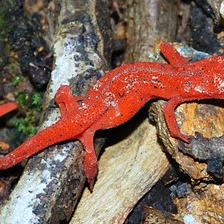

In [ ]:
img, _ = get_image(class_name="eft", idx=1, randomness=False)
img

### Inference

In [ ]:
logits, = models["mixer_base"]["model"].apply(dict(params=models["mixer_base"]["params"]), (np.array(img) / 128 - 1)[None, ...], train=False)

In [ ]:
preds = scipy.special.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}')

0.98503 : eft
0.01187 : common_newt, Triturus_vulgaris
0.00003 : hook, claw
0.00002 : sax, saxophone
0.00002 : rocking_chair, rocker
0.00002 : king_crab, Alaska_crab, Alaskan_king_crab, Alaska_king_crab, Paralithodes_camtschatica
0.00002 : axolotl, mud_puppy, Ambystoma_mexicanum
0.00002 : Pomeranian
0.00002 : stinkhorn, carrion_fungus
0.00002 : clog, geta, patten, sabot


In [ ]:
import tqdm

success_counts = {
    "mixer_base": 0,
    "mixer_sam": 0,
    "vit_sam": 0
}

total_images = 0
for image_class in os.listdir(f'./imagenet_images'):
  for idx, image_name in enumerate(tqdm.tqdm(os.listdir(f'./imagenet_images/{image_class}'), desc=f"Processing image class '{image_class}'")):
    img, _ = get_image(class_name=image_class, idx=idx, randomness=False)
    total_images += 1
    for model_name in success_counts:
      logits, = models[model_name]["model"].apply(dict(params=models[model_name]["params"]), (np.array(img) / 128 - 1)[None, ...], train=False)
      success_counts[model_name] += (imagenet_labels[logits.argmax()] == image_class)

Processing image class 'geyser': 100%|██████████| 106/106 [12:32<00:00,  7.10s/it]


In [ ]:
for model_name, value in success_counts.items():
  print(f"Accuracy for '{model_name}': {value / total_images}")

Accuracy for 'mixer_base': 0.939873417721519
Accuracy for 'mixer_sam': 0.9525316455696202
Accuracy for 'vit_sam': 0.9525316455696202


### Mixup experiments

In [ ]:
def gen_mixup_img(alpha=0.5):
  class1, class2 = "0", "0"
  while class1 == class2:
    img1, class1 = get_image()
    img2, class2 = get_image()
    if len(np.array(img1).shape) < 3 or len(np.array(img2).shape) < 3:
      class1, class2 = "0", "0"
      continue

  mixup_img = PIL.Image.fromarray((alpha * np.array(img1) + (1 - alpha) * np.array(img2)).astype("uint8"))
  return mixup_img, (class1, class2)


0.43802 : axolotl, mud_puppy, Ambystoma_mexicanum
0.07146 : geyser
0.04438 : sea_urchin
0.02669 : common_newt, Triturus_vulgaris
0.02377 : starfish, sea_star
0.02187 : eft
0.01885 : shower_curtain
0.01420 : book_jacket, dust_cover, dust_jacket, dust_wrapper
0.01413 : goldfish, Carassius_auratus
0.01381 : fountain


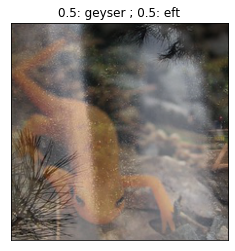

In [ ]:
mixup_img, (class1, class2) = gen_mixup_img(0.5)
logits, = models["vit_sam"]["model"].apply(dict(params=models["vit_sam"]["params"]), (np.array(mixup_img) / 128 - 1)[None, ...], train=False)

preds = scipy.special.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}')

show_img(np.array(mixup_img), title=f"0.5: {class1} ; 0.5: {class2}")


0.93130 : eft
0.04749 : common_newt, Triturus_vulgaris
0.00185 : axolotl, mud_puppy, Ambystoma_mexicanum
0.00135 : starfish, sea_star
0.00082 : thunder_snake, worm_snake, Carphophis_amoenus
0.00068 : sea_anemone, anemone
0.00057 : goldfish, Carassius_auratus
0.00055 : sea_cucumber, holothurian
0.00054 : spotted_salamander, Ambystoma_maculatum
0.00053 : slug


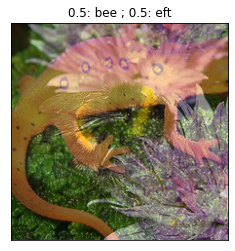

In [ ]:
mixup_img, (class1, class2) = gen_mixup_img(0.5)
logits, = models["mixer_sam"]["model"].apply(dict(params=models["mixer_sam"]["params"]), (np.array(mixup_img) / 128 - 1)[None, ...], train=False)

preds = scipy.special.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}')

show_img(np.array(mixup_img), title=f"0.5: {class1} ; 0.5: {class2}")


0.63488 : eft
0.04791 : dowitcher
0.03724 : American_coot, marsh_hen, mud_hen, water_hen, Fulica_americana
0.03599 : common_newt, Triturus_vulgaris
0.01570 : redshank, Tringa_totanus
0.01260 : ruddy_turnstone, Arenaria_interpres
0.01022 : Angora, Angora_rabbit
0.00972 : red-backed_sandpiper, dunlin, Erolia_alpina
0.00935 : geyser
0.00867 : hen


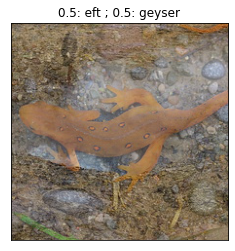

In [ ]:
mixup_img, (class1, class2) = gen_mixup_img(0.5)
logits, = models["mixer_base"]["model"].apply(dict(params=models["mixer_base"]["params"]), (np.array(mixup_img) / 128 - 1)[None, ...], train=False)


preds = scipy.special.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}')

show_img(np.array(mixup_img), title=f"0.5: {class1} ; 0.5: {class2}")


In [ ]:
import tqdm

def approximate_error_rate(model_dict, n_sessions):
  error_rates = []

  for l in tqdm.tqdm(np.linspace(0.05, 0.5, 10), desc=f"Processing lambdas"):
    mix_imgs, classes = zip(*[gen_mixup_img(l) for _ in range(n_sessions)])
    batch = np.concatenate([np.expand_dims(np.array(img), axis=0) for img in mix_imgs], axis=0) / 128 - 1
    logits = model_dict["model"].apply(dict(params=model_dict["params"]), batch, train=False)

    preds = [imagenet_labels[idx] for idx in logits.argmax(axis=1)]
    goods = sum((label in classes for label, classes in zip(preds, classes)))
    error_rates.append(1 - goods / n_sessions)
  return error_rates


In [ ]:
vit_sam_errors = approximate_error_rate(models["vit_sam"], n_sessions=100)
mixer_sam_errors = approximate_error_rate(models["mixer_sam"], n_sessions=100)
mixer_base_errors = approximate_error_rate(models["mixer_base"], n_sessions=100)

Processing lambdas: 100%|██████████| 10/10 [08:43<00:00, 52.38s/it]


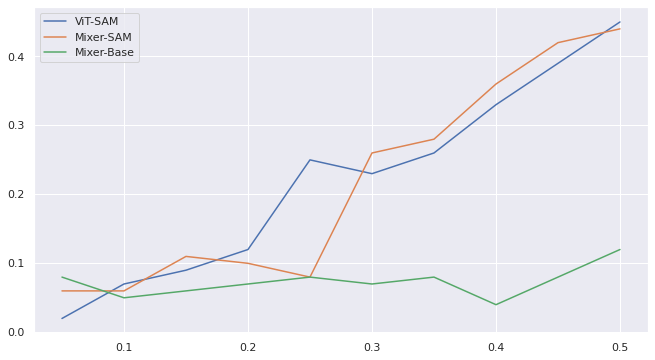

In [35]:
import seaborn as sns
sns.set()

plt.figure(figsize=(11, 6))
sns.lineplot(x=np.linspace(0.05, 0.5, 10), y=vit_sam_errors, label='ViT-SAM')
sns.lineplot(x=np.linspace(0.05, 0.5, 10), y=mixer_sam_errors, label='Mixer-SAM')
sns.lineplot(x=np.linspace(0.05, 0.5, 10), y=mixer_base_errors, label='Mixer-Base')
plt.legend()

### Результаты авторов из статьи

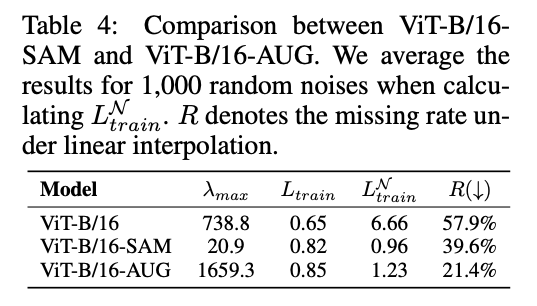